In [1]:
import sklearn.metrics
import numpy as np
from sklearn.datasets import load_iris
from sklearn.datasets import load_breast_cancer
from sklearn.datasets import load_diabetes
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt

from IPython.display import display, Image

%matplotlib inline

/Users/nkozlovskaya/env_py3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# Стандартные метрики регрессии

- Общая концепция - $\frac1n \sum\limits_{i=1}^n L(a(x_i), y_i)$

-  MAE - Mean Absolute Error - $\frac1n \sum\limits_{i=1}^n |a(x_i) - y_i|$

- MSE - Mean Squared Error - $\frac1n \sum\limits_{i=1}^n (a(x_i) - y_i)^2$

- MAPE - Mean Absolute Percentage Error - $\frac1n \sum\limits_{i=1}^n \frac{|a(x_i) - y_i|}{y_i}$

- sMAPE - symmetric Mean Absolute Percentage Error - $\frac2n \sum\limits_{i=1}^n \frac{|a(x_i) - y_i|}{a(x_i) + y_i}$

Нарисуем функции потерь и попробуем догадаться, каким цветом они обозначены:

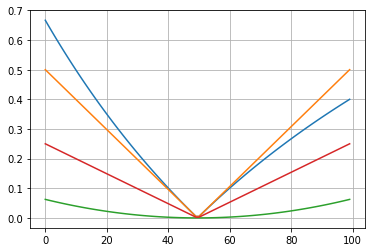

In [2]:
y_true = 0.5
y_pred = np.linspace(y_true * 0.5, y_true * 1.5, 100)

def create_regression_losses(y_true, y_pred, shuffle=True):

    loss1 = [np.abs(y_true - yp) for yp in y_pred]
    loss2 = [(y_true - yp) ** 2 for yp in y_pred]
    loss3 = [np.abs(y_true - yp) / y_true for yp in y_pred]
    loss4 = [2 * np.abs(y_true - yp) / (y_true + yp) for yp in y_pred]
    
    losses = [loss1, loss2, loss3, loss4]
    if shuffle:
        np.random.shuffle(losses)
    return losses

for loss in create_regression_losses(y_true, y_pred):
    plt.plot(loss)

plt.grid()

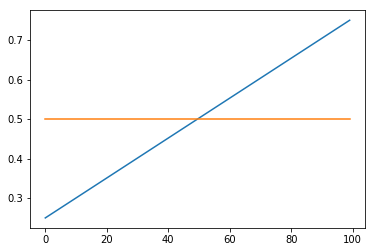

In [3]:
plt.plot(np.linspace(y_true * 0.5, y_true * 1.5, 100))
plt.plot([0.5]*100)

In [4]:
data = load_diabetes()

In [5]:
cross_val_score(RandomForestRegressor(), data.data, data.target, cv=3, 
                scoring='neg_mean_absolute_error')

array([-50.26891892, -51.44489796, -48.34693878])

In [6]:
cross_val_score(RandomForestRegressor(), data.data, data.target, cv=3, 
                scoring='neg_mean_squared_error')

array([-3791.16027027, -3579.84959184, -3651.3292517 ])

In [7]:
cross_val_score(RandomForestRegressor(), data.data, data.target, cv=3, 
                scoring='neg_mean_absolute_percentage_error')

ValueError: 'neg_mean_absolute_percentage_error' is not a valid scoring value. Valid options are ['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'completeness_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'mutual_info_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'normalized_mutual_info_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc', 'v_measure_score']

In [8]:
def absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred) / y_true)

In [9]:
def symmetric_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred) / (y_true + y_pred))

In [10]:
cross_val_score(
    RandomForestRegressor(), 
    data.data, data.target, 
    cv=3, 
    scoring=sklearn.metrics.make_scorer(
        absolute_percentage_error, greater_is_better=False)
)

array([-0.41279102, -0.43606876, -0.407509  ])

In [11]:
cross_val_score(
    RandomForestRegressor(random_state=42), 
    data.data, data.target, 
    cv=3,
    scoring=sklearn.metrics.make_scorer(
        symmetric_absolute_percentage_error, greater_is_better=False)
)

array([-0.16746928, -0.1772701 , -0.16144904])

In [12]:
def smape_scorer(estimator, X, y):
    pred = estimator.predict(X)
    return -symmetric_absolute_percentage_error(y, pred)

In [13]:
cross_val_score(
    RandomForestRegressor(random_state=42), 
    data.data, data.target, 
    cv=3, 
    scoring=smape_scorer
)

array([-0.16746928, -0.1772701 , -0.16144904])

In [14]:
cross_validate(
    RandomForestRegressor(random_state=42), 
    data.data, data.target, 
    cv=3, 
    scoring={
        'smape': smape_scorer,
        'mse': sklearn.metrics.make_scorer(sklearn.metrics.mean_squared_error, greater_is_better=False)
    },
    return_train_score=True
)

{'fit_time': array([0.02133298, 0.02109814, 0.02407575]),
 'score_time': array([0.00211501, 0.00340176, 0.00408816]),
 'test_smape': array([-0.16746928, -0.1772701 , -0.16144904]),
 'train_smape': array([-0.07686581, -0.07672183, -0.07875703]),
 'test_mse': array([-3303.04290541, -3733.33714286, -3448.65340136]),
 'train_mse': array([-762.31615646, -702.55888136, -795.8660678 ])}

### Blackbox оптимизация
- RandomSearch 
- GridSearch

In [15]:
from catboost import CatBoostRegressor

In [16]:
import warnings
warnings.filterwarnings('ignore')

In [17]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint as sp_randint
import time

def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            
clf = CatBoostRegressor(verbose=False, loss_function='MAPE')

param_dist = {"learning_rate": [10, 100],
              "border_count": sp_randint(32, 100),
              "depth": sp_randint(2, 8),
              "l2_leaf_reg": sp_randint(1, 5)
             }
n_iter_search = 10
random_search = RandomizedSearchCV(
    clf, param_distributions=param_dist, n_iter=n_iter_search, cv=3, 
    scoring=sklearn.metrics.make_scorer(
        absolute_percentage_error, greater_is_better=False)
)

start = time.time()
random_search.fit(data.data, data.target)
report(random_search.cv_results_)
param_grid = {"depth": [4, 6, 8],
              "learning_rate": [10, 100],
              "border_count": [32, 64, 100],
             }
grid_search = GridSearchCV(
    clf, param_grid=param_grid, cv=3, scoring=sklearn.metrics.make_scorer(
        absolute_percentage_error, greater_is_better=False)
)
grid_search.fit(data.data, data.target)
report(grid_search.cv_results_)

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease l

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease l

Model with rank: 1
Mean validation score: -0.356 (std: 0.016)
Parameters: {'border_count': 59, 'depth': 4, 'l2_leaf_reg': 3, 'learning_rate': 100}

Model with rank: 2
Mean validation score: -0.357 (std: 0.011)
Parameters: {'border_count': 39, 'depth': 4, 'l2_leaf_reg': 3, 'learning_rate': 100}

Model with rank: 3
Mean validation score: -0.359 (std: 0.009)
Parameters: {'border_count': 70, 'depth': 2, 'l2_leaf_reg': 3, 'learning_rate': 100}



learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease l

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease l

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease l

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


Model with rank: 1
Mean validation score: -0.355 (std: 0.013)
Parameters: {'border_count': 100, 'depth': 4, 'learning_rate': 100}

Model with rank: 2
Mean validation score: -0.360 (std: 0.012)
Parameters: {'border_count': 32, 'depth': 4, 'learning_rate': 100}

Model with rank: 3
Mean validation score: -0.360 (std: 0.006)
Parameters: {'border_count': 64, 'depth': 8, 'learning_rate': 100}



In [25]:
report(random_search.cv_results_)

Model with rank: 1
Mean validation score: -0.356 (std: 0.016)
Parameters: {'border_count': 59, 'depth': 4, 'l2_leaf_reg': 3, 'learning_rate': 100}

Model with rank: 2
Mean validation score: -0.357 (std: 0.011)
Parameters: {'border_count': 39, 'depth': 4, 'l2_leaf_reg': 3, 'learning_rate': 100}

Model with rank: 3
Mean validation score: -0.359 (std: 0.009)
Parameters: {'border_count': 70, 'depth': 2, 'l2_leaf_reg': 3, 'learning_rate': 100}



In [26]:
report(grid_search.cv_results_)

Model with rank: 1
Mean validation score: -0.355 (std: 0.013)
Parameters: {'border_count': 100, 'depth': 4, 'learning_rate': 100}

Model with rank: 2
Mean validation score: -0.360 (std: 0.012)
Parameters: {'border_count': 32, 'depth': 4, 'learning_rate': 100}

Model with rank: 3
Mean validation score: -0.360 (std: 0.006)
Parameters: {'border_count': 64, 'depth': 8, 'learning_rate': 100}



### Несколько свойств оптимизации метрик регрессии

- $\sum\limits_{i=1}^n \left(a(x_i) - y_i\right)^2 \to \min \implies a(x_i) \approx E(y \mid x = x_i)$

- $\sum\limits_{i=1}^n \left|~a(x_i) - y_i~\right| \to \min \implies a(x_i) \approx median(y \mid x = x_i)$

- $\sum\limits_{i=1}^n \alpha~(a(x_i) - y_i)~I\{a(x_i) \geq y_i\} + (1-\alpha)~(y_i - a(x_i))~I\{a(x_i) < y_i\} \to \min \implies a(x_i) \approx Z_{1 - \alpha}(y \mid x = x_i)$

Пример: пусть есть магазин продуктов, завозим какое-то количество товаров. Хотим при обучении учитывать то, что если привозим слишком много, то продукты портятся (потратили 200 рублей на единицу товара). Если слишком мало, то недополучаем деньги (недополучаем 150 рублей на единицу товара). То есть если $y>a(x)$:  $150(y-a(x))$, если $y <= a(x)$:
$200(a(x)-y)$.

**Докажите утверждения в случаях, если все $x_i$ одинаковые**

### Проверим пару из этих утверждений

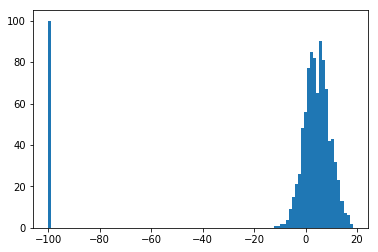

In [27]:
loc, scale = 5, 5
y_true = np.random.normal(loc, scale, 1000)
y_true[:100] = -100
plt.hist(y_true, bins=100);

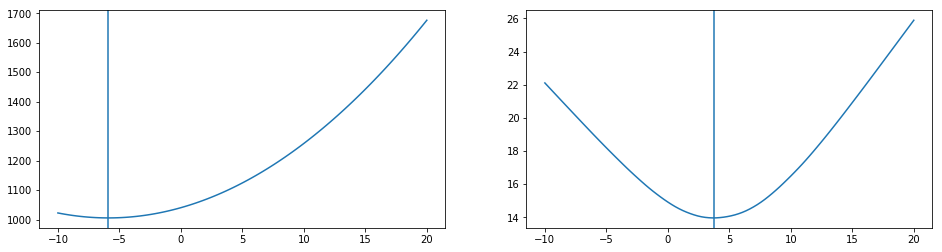

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(16,4))

y_pred = np.linspace(loc - 3 * scale, loc + 3 * scale, 100)

loss = [np.mean((y_true - yp) ** 2) for yp in y_pred]
axes[0].plot(y_pred, loss)
axes[0].axvline(np.mean(y_true))

loss = [np.mean(np.abs(y_true - yp)) for yp in y_pred]
axes[1].plot(y_pred, loss)
axes[1].axvline(np.median(y_true))

### Как оптимизировать MAPE через оптимизацию MAE?

Пусть p - prediction, t - target, 

Хотим оптимизировать MAPE: $|\frac{p-t}{t}|$.

Будем оптимизировать MAE $|p-t|$ с весами $w = \frac{1}{t}$.

Так устроена оптимизация MAPE в catboost (метод 1го порядка). При обучении на MAPE надо проверять, что в целевой переменной нет нулей ( чтобы избежать деление на 0).

In [29]:
from sklearn.datasets import load_diabetes
from sklearn.cross_validation import train_test_split
from catboost import CatBoostRegressor

data = load_diabetes()

X_train, X_test, y_train, y_test = train_test_split(data.data, data.target)

In [30]:
cross_val_score(
    CatBoostRegressor(verbose=False), 
    data.data, data.target, 
    cv=3, 
    scoring=sklearn.metrics.make_scorer(absolute_percentage_error, greater_is_better=False)
)

array([-0.3892627 , -0.41818326, -0.37767396])

In [31]:
cross_val_score(
    CatBoostRegressor(verbose=False, loss_function='MAPE'), 
    data.data, data.target, 
    cv=3, 
    scoring=sklearn.metrics.make_scorer(absolute_percentage_error, greater_is_better=False)
)

array([-0.99740723, -0.99750226, -0.99761193])

In [32]:
cross_val_score(
    CatBoostRegressor(verbose=False, loss_function='MAPE', learning_rate=10), 
    data.data, data.target, 
    cv=3, 
    scoring=sklearn.metrics.make_scorer(absolute_percentage_error, greater_is_better=False)
)

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease l

array([-0.5186262 , -0.52605012, -0.54064932])

In [34]:
cross_val_score(
    CatBoostRegressor(verbose=False, loss_function='MAPE', learning_rate=100), 
    data.data, data.target, 
    cv=3, 
    scoring=sklearn.metrics.make_scorer(absolute_percentage_error, greater_is_better=False)
)

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease l

array([-0.37665094, -0.37042134, -0.34880407])

Пусть p - prediction, t - target, $\delta = p - t.$

Идея: попробуем найти такое преобразование целевой переменной, для которого будет верно: $P - T \approx \frac{p-t}{t},$
где $$P = f(p) = f(t+\delta) \approx f(t) + f^\prime(t) \delta + .. ,$$ 
$$ T = f(t).$$
Тогда в предположении $\delta \rightarrow 0$ имеем: $$P - T \approx f(t) + f^\prime(t) \delta - f(t) \approx \frac{p-t}{t}$$

$$\left( f^\prime(t) \delta \approx \frac{\delta}{t}; f^\prime(t) \approx \frac{1}{t} \right)$$

$$f(t) \approx \log(t) + C$$


Таким образом, минимизируя $MAE = \frac{1}{n} \sum_{i=1}^n |P_i - T_i|$ для $\log(t),$ будем минимизировать $MAPE = \frac{100}{n}\sum_{i=1}^n |\frac{p_i - t_i}{t_i}|$ для $t$ А смещение этой аппроксимации $C$ подберем по валидации/фолдам. 

Методами 2го порядка (например, xgboost) оптимизировать MAE напрямую не получится

### Аппроксимации MAE

$$|x| \approx \ln(\cosh(x))$$

$$|x| \approx \dfrac{c^2\ln\left(\frac{x^2}{c^2}+1\right)}{2} $$

$$|x| \approx c^2\left(\dfrac{\left|x\right|}{c}-\ln\left(\dfrac{\left|x\right|}{c}+1\right)\right)$$


Text(0.5, 1.0, 'fair')

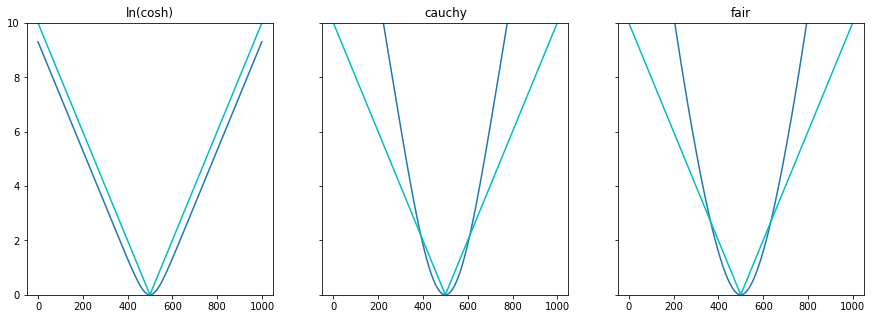

In [35]:
def log_cosh_loss(x):
    return np.log(np.cosh(x))

c=5
def cauchy_loss(x):
    return c ** 2 * np.log(x ** 2 * 1./ c ** 2 + 1) / 2


def fair_loss(x):
    return c ** 2 * (np.abs(x) *1. / c - np.log(np.abs(x) * 1. / c + 1) )


_, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15,5))
ax1.set_ylim([0, 10])

ax1.plot(list(map(log_cosh_loss, np.linspace(-10, 10, 1000))))
ax1.plot(list(map(abs, np.linspace(-10, 10, 1000))), color='c')
ax1.set_title('ln(cosh)')

ax2.plot(list(map(cauchy_loss, np.linspace(-10, 10, 1000))))
ax2.plot(list(map(abs, np.linspace(-10, 10, 1000))), color='c')
ax2.set_title('cauchy')

ax3.plot(list(map(fair_loss, np.linspace(-10, 10, 1000))))
ax3.plot(list(map(abs, np.linspace(-10, 10, 1000))), color='c')
ax3.set_title('fair')

In [36]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error

def eval_mae_log(preds, dtrain):
    y = dtrain.get_label()
    return 'mae on log', mean_absolute_error(y, preds)
    
def logcoshobj(preds, dtrain):
    labels = dtrain.get_label()
    grad = np.tanh(preds-labels)
    hess  =  1. - grad * grad
    return grad, hess


fair_constant = 100 #the lower the "slower/smoother" loss

def cauchy_obj(preds, dtrain):
    labels = dtrain.get_label()
    x  = preds-labels
    grad = x / (x ** 2 / fair_constant ** 2 + 1)
    hess = -fair_constant ** 2 * (x ** 2 - fair_constant ** 2) / (x ** 2 + fair_constant ** 2) ** 2
    return grad, hess

def fair_obj(preds, dtrain):
    labels = dtrain.get_label()
    x = (preds - labels)
    den = abs(x) + fair_constant
    grad = fair_constant * x / (den)
    hess = fair_constant * fair_constant / (den * den)
    return grad, hess

def get_params():
    params = {}
    params["objective"] = "reg:linear"
    params["booster"] = "dart" 
    params["feval"] = eval_mae_log
    params["num_boost_round"] = 1000
    params["max_depth"] = 14 
    params["eta"] = 0.55 
    params["gamma"] = 1 
    params["lambda"] = 0.9  
    params["alpha"] = 0.2 
    params["seed"] = 0
    params['normalize_type'] = 'forest'
    params["min_child_weight"] = 1
    params["base_score"] = 10
    params["subsample"] = 1
    return params

In [37]:
for loss in [fair_obj, logcoshobj, cauchy_obj]:
    xgtrain = xgb.DMatrix(X_train, label=np.log(y_train))
    xgval = xgb.DMatrix(X_test, label=np.log(y_test))
    bst = xgb.train(get_params(), xgtrain, obj=loss)
    pred_val = bst.predict(xgval)
    print (min([absolute_percentage_error(y_test, np.exp(pred_val) * c) for c in np.linspace(0, 2, 1000)]))

0.34924861847830446
1.0
0.3650361065702477


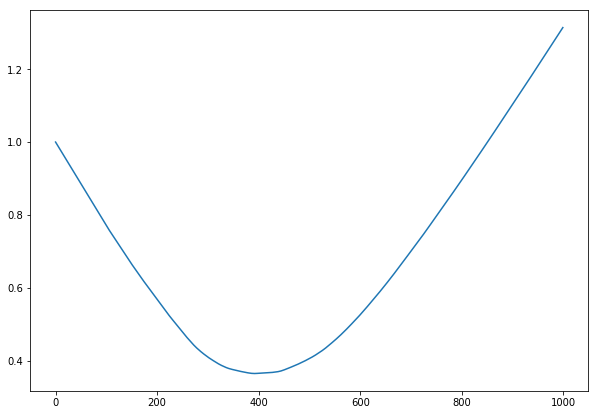

In [38]:
mp = [absolute_percentage_error(y_test, np.exp(pred_val) * c) 
      for c in np.linspace(0, 2, 1000)]

plt.figure(figsize=(10, 7))
plt.plot(np.array(mp))

In [84]:
np.linspace(0, 2, 1000)[np.array(mp).argmin()]

0.7847847847847848

Как еще можно подобрать оптимальную константу C?

In [39]:
from scipy.optimize import minimize 

fun = lambda alpha: absolute_percentage_error(y_test, alpha * np.exp(pred_val))
res = minimize(fun, [0.8], method='Nelder-Mead')
print ('best param alpha = {}'.format(res.x))
print ('best mape = {}'.format(res.fun))

best param alpha = [0.78546875]
best mape = 0.3650267265980002


In [40]:
import hyperopt
from scipy.optimize import differential_evolution 

### Использовать три основных подхода к оптимизации "чёрного ящика": hyperopt, scipy.optimize.minimize и scipy.optimize.differential_evolution

Дифференциальная эволюция {https://ru.wikipedia.org/wiki/Дифференциальная_эволюция} 
https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.differential_evolution.html
- стохастический алгоритм оптимизации для нахождения глобального минимума (или максимума) недифференцируемых, нелинейных, мультимодальных (имеющих, возможно, большое число локальных экстремумов) функций от многих переменных
- требует только возможности вычислять значения целевой функций (не её производных)

In [41]:
X_train_add = np.ones((X_train.shape[0], X_train.shape[1]+1))
X_train_add[:, :-1] = X_train
X_test_add = np.ones((X_test.shape[0], X_test.shape[1]+1))
X_test_add[:, :-1] = X_test

num_coeff = X_train.shape[1] + 1

In [74]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression(fit_intercept=False).fit(X_train_add, y_train)
print(absolute_percentage_error(y_test, lr.predict(X_test_add)))
print (absolute_percentage_error(y_train, lr.predict(X_train_add)))

0.428780729334376
0.37450336256709993


In [75]:
import scipy.optimize

In [76]:
DEFAULT_SAMPLES_COUNT = 10

def func_4_optimization(coeffs):
    coeffs = np.array(coeffs)
    pred = np.dot(X_train_add, coeffs)
    return absolute_percentage_error(y_train, pred)

- На каждой итерации берем поколение. Для каждого вектора из старого поколения выбираем 3 случайных
- Создаем mutant vector:

$v = v_1 + F (v_2 - v_3)$
- Делаем скрещивание (некоторые координаты замещаем координатой исходного вектора)
- Проверяем, лучше ли оказался получившийся вектор. Если лучше, заменяем им исходный

Основные параметры:
    - popsize 
    - mutation [0, 2]
    - recombination [0, 1]

In [45]:
def scipy_differential_evolution_exp(samples_count=DEFAULT_SAMPLES_COUNT, **kwargs):
    best_result = None
    for seed in range(samples_count):
        result = scipy.optimize.differential_evolution(
            func_4_optimization, 
            bounds=[(-700, 700)] * num_coeff,
            seed=seed,
            **kwargs
        )
        if best_result is None or result.fun < best_result.fun:
            best_result = result
    print ('Best point:', best_result.x)
    print ('Best value:', func_4_optimization(best_result.x))
    print ()
    
def diff_evolution_experiment_1(maxiter, popsize, strategy='best1bin'):
    scipy_differential_evolution_exp(maxiter=maxiter, popsize=popsize, strategy=strategy)

In [46]:
diff_evolution_experiment_1(1000, 15, 'best1bin')

Best point: [  42.6954405  -178.88667817  459.66059796  196.58340698  290.23517892
 -515.73921772 -168.89197498  253.6211431   453.09565497  -91.98270772
  124.61966378]
Best value: 0.33201865682739107



In [47]:
diff_evolution_experiment_1(1000, 15, 'best2bin')

Best point: [  84.95333979 -187.44730621  436.55727634  208.22510731  223.94985151
 -475.07353519 -137.14505775  295.49254523  430.55321331 -107.8752657
  123.81069816]
Best value: 0.3320151927707597



In [48]:
diff_evolution_experiment_1(maxiter=1000, popsize=15, strategy='best1exp')

Best point: [  65.35584124 -184.09939442  451.51740871  203.39254763  254.95487857
 -504.54283533 -139.60840588  296.09441299  443.45904782 -102.94460496
  124.32159345]
Best value: 0.3318976008380604



Градиентные методы плохо ищут решения, но хорошо дотюнивают, имея неплохое начальное приближение.

Попробуйте подать в SGDRegressor начальные веса от одной из функций (используйте параметр warn_start в SGDRegressor и coef_init в fit)

### hyperopt
- позволяет описывать пространство параметров, в котором ищем минимум

In [62]:
from hyperopt import hp, fmin, Trials, tpe
import pickle
import time
from hyperopt import fmin, tpe, hp, STATUS_OK

In [60]:
def run_val(params):
    bst_params = {
        'loss_function': 'MAPE', 
        'learning_rate': params['learning_rate'], 
        'verbose': -1
    }
    ctb_model = CatBoostRegressor(**bst_params).fit(X_train, y_train)
    result = {
        'mape': absolute_percentage_error(y_test, ctb_model.predict(X_test)), 
        'status': STATUS_OK, 
        'loss': absolute_percentage_error(y_test, ctb_model.predict(X_test))
    }
    return result

In [63]:
space = {
    'learning_rate': hp.uniform('learning_rate', 0, 100)
}

trials = Trials()

_ = fmin(fn=lambda params: run_val(params), space=space, algo=tpe.suggest, 
         max_evals=10, trials=trials)#, rseed=1)

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease l

In [73]:
_

{'learning_rate': 83.72979427535671}

In [78]:
trials.best_trial

{'state': 2,
 'tid': 7,
 'spec': None,
 'result': {'mape': 0.36524813551720636,
  'status': 'ok',
  'loss': 0.36524813551720636},
 'misc': {'tid': 7,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idxs': {'learning_rate': [7]},
  'vals': {'learning_rate': [83.72979427535671]}},
 'exp_key': None,
 'owner': None,
 'version': 0,
 'book_time': datetime.datetime(2019, 3, 23, 8, 38, 53, 24000),
 'refresh_time': datetime.datetime(2019, 3, 23, 8, 39, 3, 168000)}

In [81]:
trials.trials

[{'state': 2,
  'tid': 0,
  'spec': None,
  'result': {'mape': 0.41693296953939424,
   'status': 'ok',
   'loss': 0.41693296953939424},
  'misc': {'tid': 0,
   'cmd': ('domain_attachment', 'FMinIter_Domain'),
   'workdir': None,
   'idxs': {'learning_rate': [0]},
   'vals': {'learning_rate': [25.32120457117959]}},
  'exp_key': None,
  'owner': None,
  'version': 0,
  'book_time': datetime.datetime(2019, 3, 23, 8, 37, 59, 172000),
  'refresh_time': datetime.datetime(2019, 3, 23, 8, 38, 6, 501000)},
 {'state': 2,
  'tid': 1,
  'spec': None,
  'result': {'mape': 0.7953392409893438,
   'status': 'ok',
   'loss': 0.7953392409893438},
  'misc': {'tid': 1,
   'cmd': ('domain_attachment', 'FMinIter_Domain'),
   'workdir': None,
   'idxs': {'learning_rate': [1]},
   'vals': {'learning_rate': [2.5531091834359976]}},
  'exp_key': None,
  'owner': None,
  'version': 0,
  'book_time': datetime.datetime(2019, 3, 23, 8, 38, 6, 502000),
  'refresh_time': datetime.datetime(2019, 3, 23, 8, 38, 11, 69400

## Кастомные лоссы в NN

In [65]:
import tensorflow as tf
import keras.losses

def mape(y_true, y_pred):
    loss = tf.divide(tf.abs(y_true - y_pred), y_true)
    return tf.reduce_mean(loss, axis=-1)

from keras.models import Sequential
from keras.layers import Dense, Activation

Using TensorFlow backend.


In [66]:
model = Sequential()
model.add(Dense(50, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='linear'))

Instructions for updating:
Colocations handled automatically by placer.


In [67]:
keras.losses.mape = mape
model.compile(optimizer='adam', loss=mape, metrics=['mape'])
history = model.fit(X_train, y_train, epochs=500, validation_data=[X_test, y_test])

Instructions for updating:
Use tf.cast instead.
Train on 331 samples, validate on 111 samples
Epoch 1/500
331/331 [==============================] - 0s 1ms/step - loss: 0.9995 - mean_absolute_percentage_error: 99.9514 - val_loss: 0.9990 - val_mean_absolute_percentage_error: 99.9016
Epoch 2/500
331/331 [==============================] - 0s 62us/step - loss: 0.9985 - mean_absolute_percentage_error: 99.8494 - val_loss: 0.9979 - val_mean_absolute_percentage_error: 99.7881
Epoch 3/500
331/331 [==============================] - 0s 54us/step - loss: 0.9971 - mean_absolute_percentage_error: 99.7130 - val_loss: 0.9963 - val_mean_absolute_percentage_error: 99.6347
Epoch 4/500
331/331 [==============================] - 0s 63us/step - loss: 0.9953 - mean_absolute_percentage_error: 99.5306 - val_loss: 0.9943 - val_mean_absolute_percentage_error: 99.4282
Epoch 5/500
331/331 [==============================] - 0s 65us/step - loss: 0.9928 - mean_absolute_percentage_error: 99.2845 - val_loss: 0.9915 - v

331/331 [==============================] - 0s 65us/step - loss: 0.4541 - mean_absolute_percentage_error: 45.4127 - val_loss: 0.4546 - val_mean_absolute_percentage_error: 45.4575
Epoch 43/500
331/331 [==============================] - 0s 55us/step - loss: 0.4518 - mean_absolute_percentage_error: 45.1784 - val_loss: 0.4512 - val_mean_absolute_percentage_error: 45.1197
Epoch 44/500
331/331 [==============================] - 0s 49us/step - loss: 0.4499 - mean_absolute_percentage_error: 44.9920 - val_loss: 0.4480 - val_mean_absolute_percentage_error: 44.8047
Epoch 45/500
331/331 [==============================] - 0s 49us/step - loss: 0.4481 - mean_absolute_percentage_error: 44.8056 - val_loss: 0.4456 - val_mean_absolute_percentage_error: 44.5642
Epoch 46/500
331/331 [==============================] - 0s 49us/step - loss: 0.4462 - mean_absolute_percentage_error: 44.6180 - val_loss: 0.4438 - val_mean_absolute_percentage_error: 44.3849
Epoch 47/500
331/331 [==============================] - 0s

Epoch 85/500
331/331 [==============================] - 0s 51us/step - loss: 0.3830 - mean_absolute_percentage_error: 38.3040 - val_loss: 0.3791 - val_mean_absolute_percentage_error: 37.9144
Epoch 86/500
331/331 [==============================] - 0s 60us/step - loss: 0.3820 - mean_absolute_percentage_error: 38.1959 - val_loss: 0.3785 - val_mean_absolute_percentage_error: 37.8503
Epoch 87/500
331/331 [==============================] - 0s 67us/step - loss: 0.3812 - mean_absolute_percentage_error: 38.1237 - val_loss: 0.3778 - val_mean_absolute_percentage_error: 37.7813
Epoch 88/500
331/331 [==============================] - 0s 71us/step - loss: 0.3804 - mean_absolute_percentage_error: 38.0449 - val_loss: 0.3772 - val_mean_absolute_percentage_error: 37.7222
Epoch 89/500
331/331 [==============================] - 0s 82us/step - loss: 0.3796 - mean_absolute_percentage_error: 37.9634 - val_loss: 0.3766 - val_mean_absolute_percentage_error: 37.6648
Epoch 90/500
331/331 [=======================

Epoch 128/500
331/331 [==============================] - 0s 62us/step - loss: 0.3599 - mean_absolute_percentage_error: 35.9858 - val_loss: 0.3631 - val_mean_absolute_percentage_error: 36.3079
Epoch 129/500
331/331 [==============================] - 0s 63us/step - loss: 0.3596 - mean_absolute_percentage_error: 35.9599 - val_loss: 0.3626 - val_mean_absolute_percentage_error: 36.2591
Epoch 130/500
331/331 [==============================] - 0s 52us/step - loss: 0.3591 - mean_absolute_percentage_error: 35.9086 - val_loss: 0.3624 - val_mean_absolute_percentage_error: 36.2437
Epoch 131/500
331/331 [==============================] - 0s 71us/step - loss: 0.3589 - mean_absolute_percentage_error: 35.8872 - val_loss: 0.3623 - val_mean_absolute_percentage_error: 36.2253
Epoch 132/500
331/331 [==============================] - 0s 76us/step - loss: 0.3583 - mean_absolute_percentage_error: 35.8347 - val_loss: 0.3623 - val_mean_absolute_percentage_error: 36.2270
Epoch 133/500
331/331 [=================

Epoch 171/500
331/331 [==============================] - 0s 68us/step - loss: 0.3459 - mean_absolute_percentage_error: 34.5935 - val_loss: 0.3593 - val_mean_absolute_percentage_error: 35.9273
Epoch 172/500
331/331 [==============================] - 0s 64us/step - loss: 0.3460 - mean_absolute_percentage_error: 34.6036 - val_loss: 0.3588 - val_mean_absolute_percentage_error: 35.8802
Epoch 173/500
331/331 [==============================] - 0s 66us/step - loss: 0.3455 - mean_absolute_percentage_error: 34.5533 - val_loss: 0.3589 - val_mean_absolute_percentage_error: 35.8879
Epoch 174/500
331/331 [==============================] - 0s 55us/step - loss: 0.3450 - mean_absolute_percentage_error: 34.4994 - val_loss: 0.3589 - val_mean_absolute_percentage_error: 35.8865
Epoch 175/500
331/331 [==============================] - 0s 64us/step - loss: 0.3445 - mean_absolute_percentage_error: 34.4496 - val_loss: 0.3591 - val_mean_absolute_percentage_error: 35.9126
Epoch 176/500
331/331 [=================

Epoch 214/500
331/331 [==============================] - 0s 61us/step - loss: 0.3364 - mean_absolute_percentage_error: 33.6410 - val_loss: 0.3611 - val_mean_absolute_percentage_error: 36.1143
Epoch 215/500
331/331 [==============================] - 0s 60us/step - loss: 0.3367 - mean_absolute_percentage_error: 33.6719 - val_loss: 0.3615 - val_mean_absolute_percentage_error: 36.1455
Epoch 216/500
331/331 [==============================] - 0s 53us/step - loss: 0.3360 - mean_absolute_percentage_error: 33.5996 - val_loss: 0.3614 - val_mean_absolute_percentage_error: 36.1357
Epoch 217/500
331/331 [==============================] - 0s 63us/step - loss: 0.3358 - mean_absolute_percentage_error: 33.5829 - val_loss: 0.3613 - val_mean_absolute_percentage_error: 36.1280
Epoch 218/500
331/331 [==============================] - 0s 57us/step - loss: 0.3367 - mean_absolute_percentage_error: 33.6653 - val_loss: 0.3618 - val_mean_absolute_percentage_error: 36.1759
Epoch 219/500
331/331 [=================

Epoch 257/500
331/331 [==============================] - 0s 55us/step - loss: 0.3312 - mean_absolute_percentage_error: 33.1205 - val_loss: 0.3631 - val_mean_absolute_percentage_error: 36.3097
Epoch 258/500
331/331 [==============================] - 0s 58us/step - loss: 0.3317 - mean_absolute_percentage_error: 33.1699 - val_loss: 0.3632 - val_mean_absolute_percentage_error: 36.3242
Epoch 259/500
331/331 [==============================] - 0s 51us/step - loss: 0.3313 - mean_absolute_percentage_error: 33.1350 - val_loss: 0.3624 - val_mean_absolute_percentage_error: 36.2399
Epoch 260/500
331/331 [==============================] - 0s 63us/step - loss: 0.3310 - mean_absolute_percentage_error: 33.1045 - val_loss: 0.3620 - val_mean_absolute_percentage_error: 36.2023
Epoch 261/500
331/331 [==============================] - 0s 51us/step - loss: 0.3311 - mean_absolute_percentage_error: 33.1061 - val_loss: 0.3623 - val_mean_absolute_percentage_error: 36.2273
Epoch 262/500
331/331 [=================

Epoch 300/500
331/331 [==============================] - 0s 59us/step - loss: 0.3279 - mean_absolute_percentage_error: 32.7944 - val_loss: 0.3613 - val_mean_absolute_percentage_error: 36.1273
Epoch 301/500
331/331 [==============================] - 0s 83us/step - loss: 0.3277 - mean_absolute_percentage_error: 32.7694 - val_loss: 0.3612 - val_mean_absolute_percentage_error: 36.1150
Epoch 302/500
331/331 [==============================] - 0s 52us/step - loss: 0.3275 - mean_absolute_percentage_error: 32.7509 - val_loss: 0.3613 - val_mean_absolute_percentage_error: 36.1272
Epoch 303/500
331/331 [==============================] - 0s 67us/step - loss: 0.3274 - mean_absolute_percentage_error: 32.7407 - val_loss: 0.3611 - val_mean_absolute_percentage_error: 36.1099
Epoch 304/500
331/331 [==============================] - 0s 65us/step - loss: 0.3275 - mean_absolute_percentage_error: 32.7484 - val_loss: 0.3612 - val_mean_absolute_percentage_error: 36.1247
Epoch 305/500
331/331 [=================

Epoch 343/500
331/331 [==============================] - 0s 50us/step - loss: 0.3254 - mean_absolute_percentage_error: 32.5448 - val_loss: 0.3598 - val_mean_absolute_percentage_error: 35.9849
Epoch 344/500
331/331 [==============================] - 0s 58us/step - loss: 0.3254 - mean_absolute_percentage_error: 32.5421 - val_loss: 0.3595 - val_mean_absolute_percentage_error: 35.9536
Epoch 345/500
331/331 [==============================] - 0s 53us/step - loss: 0.3254 - mean_absolute_percentage_error: 32.5424 - val_loss: 0.3596 - val_mean_absolute_percentage_error: 35.9584
Epoch 346/500
331/331 [==============================] - 0s 63us/step - loss: 0.3253 - mean_absolute_percentage_error: 32.5306 - val_loss: 0.3591 - val_mean_absolute_percentage_error: 35.9136
Epoch 347/500
331/331 [==============================] - 0s 56us/step - loss: 0.3253 - mean_absolute_percentage_error: 32.5322 - val_loss: 0.3593 - val_mean_absolute_percentage_error: 35.9255
Epoch 348/500
331/331 [=================

Epoch 386/500
331/331 [==============================] - 0s 64us/step - loss: 0.3236 - mean_absolute_percentage_error: 32.3610 - val_loss: 0.3592 - val_mean_absolute_percentage_error: 35.9189
Epoch 387/500
331/331 [==============================] - 0s 88us/step - loss: 0.3235 - mean_absolute_percentage_error: 32.3451 - val_loss: 0.3587 - val_mean_absolute_percentage_error: 35.8701
Epoch 388/500
331/331 [==============================] - 0s 71us/step - loss: 0.3238 - mean_absolute_percentage_error: 32.3823 - val_loss: 0.3589 - val_mean_absolute_percentage_error: 35.8926
Epoch 389/500
331/331 [==============================] - 0s 64us/step - loss: 0.3233 - mean_absolute_percentage_error: 32.3262 - val_loss: 0.3583 - val_mean_absolute_percentage_error: 35.8327
Epoch 390/500
331/331 [==============================] - 0s 60us/step - loss: 0.3240 - mean_absolute_percentage_error: 32.3977 - val_loss: 0.3578 - val_mean_absolute_percentage_error: 35.7766
Epoch 391/500
331/331 [=================

Epoch 429/500
331/331 [==============================] - 0s 68us/step - loss: 0.3220 - mean_absolute_percentage_error: 32.1952 - val_loss: 0.3587 - val_mean_absolute_percentage_error: 35.8684
Epoch 430/500
331/331 [==============================] - 0s 69us/step - loss: 0.3220 - mean_absolute_percentage_error: 32.1957 - val_loss: 0.3587 - val_mean_absolute_percentage_error: 35.8733
Epoch 431/500
331/331 [==============================] - 0s 88us/step - loss: 0.3220 - mean_absolute_percentage_error: 32.1993 - val_loss: 0.3581 - val_mean_absolute_percentage_error: 35.8065
Epoch 432/500
331/331 [==============================] - 0s 93us/step - loss: 0.3218 - mean_absolute_percentage_error: 32.1847 - val_loss: 0.3583 - val_mean_absolute_percentage_error: 35.8307
Epoch 433/500
331/331 [==============================] - 0s 91us/step - loss: 0.3218 - mean_absolute_percentage_error: 32.1822 - val_loss: 0.3579 - val_mean_absolute_percentage_error: 35.7882
Epoch 434/500
331/331 [=================

Epoch 472/500
331/331 [==============================] - 0s 57us/step - loss: 0.3206 - mean_absolute_percentage_error: 32.0634 - val_loss: 0.3588 - val_mean_absolute_percentage_error: 35.8842
Epoch 473/500
331/331 [==============================] - 0s 58us/step - loss: 0.3206 - mean_absolute_percentage_error: 32.0568 - val_loss: 0.3585 - val_mean_absolute_percentage_error: 35.8494
Epoch 474/500
331/331 [==============================] - 0s 55us/step - loss: 0.3206 - mean_absolute_percentage_error: 32.0645 - val_loss: 0.3573 - val_mean_absolute_percentage_error: 35.7289
Epoch 475/500
331/331 [==============================] - 0s 93us/step - loss: 0.3207 - mean_absolute_percentage_error: 32.0705 - val_loss: 0.3573 - val_mean_absolute_percentage_error: 35.7343
Epoch 476/500
331/331 [==============================] - 0s 83us/step - loss: 0.3205 - mean_absolute_percentage_error: 32.0492 - val_loss: 0.3584 - val_mean_absolute_percentage_error: 35.8401
Epoch 477/500
331/331 [=================

In [68]:
history.history.keys()

dict_keys(['val_loss', 'val_mean_absolute_percentage_error', 'loss', 'mean_absolute_percentage_error'])

In [69]:
keras.losses.mape = mape
model.compile(optimizer='adam', loss=mape, metrics=['mape'])
history = model.fit(X_train, y_train, epochs=500, validation_data=[X_test, y_test])

Train on 331 samples, validate on 111 samples
Epoch 1/500
331/331 [==============================] - 0s 1ms/step - loss: 0.3204 - mean_absolute_percentage_error: 32.0358 - val_loss: 0.3589 - val_mean_absolute_percentage_error: 35.8936
Epoch 2/500
331/331 [==============================] - 0s 52us/step - loss: 0.3198 - mean_absolute_percentage_error: 31.9788 - val_loss: 0.3587 - val_mean_absolute_percentage_error: 35.8705
Epoch 3/500
331/331 [==============================] - 0s 55us/step - loss: 0.3198 - mean_absolute_percentage_error: 31.9845 - val_loss: 0.3587 - val_mean_absolute_percentage_error: 35.8654
Epoch 4/500
331/331 [==============================] - 0s 76us/step - loss: 0.3197 - mean_absolute_percentage_error: 31.9679 - val_loss: 0.3596 - val_mean_absolute_percentage_error: 35.9600
Epoch 5/500
331/331 [==============================] - 0s 56us/step - loss: 0.3197 - mean_absolute_percentage_error: 31.9713 - val_loss: 0.3586 - val_mean_absolute_percentage_error: 35.8599
Epoch

Epoch 44/500
331/331 [==============================] - 0s 67us/step - loss: 0.3186 - mean_absolute_percentage_error: 31.8580 - val_loss: 0.3577 - val_mean_absolute_percentage_error: 35.7687
Epoch 45/500
331/331 [==============================] - 0s 64us/step - loss: 0.3188 - mean_absolute_percentage_error: 31.8770 - val_loss: 0.3586 - val_mean_absolute_percentage_error: 35.8620
Epoch 46/500
331/331 [==============================] - 0s 65us/step - loss: 0.3187 - mean_absolute_percentage_error: 31.8693 - val_loss: 0.3573 - val_mean_absolute_percentage_error: 35.7329
Epoch 47/500
331/331 [==============================] - 0s 77us/step - loss: 0.3185 - mean_absolute_percentage_error: 31.8520 - val_loss: 0.3568 - val_mean_absolute_percentage_error: 35.6833
Epoch 48/500
331/331 [==============================] - 0s 78us/step - loss: 0.3186 - mean_absolute_percentage_error: 31.8562 - val_loss: 0.3570 - val_mean_absolute_percentage_error: 35.7016
Epoch 49/500
331/331 [=======================

Epoch 87/500
331/331 [==============================] - 0s 74us/step - loss: 0.3175 - mean_absolute_percentage_error: 31.7546 - val_loss: 0.3567 - val_mean_absolute_percentage_error: 35.6742
Epoch 88/500
331/331 [==============================] - 0s 84us/step - loss: 0.3175 - mean_absolute_percentage_error: 31.7498 - val_loss: 0.3568 - val_mean_absolute_percentage_error: 35.6790
Epoch 89/500
331/331 [==============================] - 0s 68us/step - loss: 0.3175 - mean_absolute_percentage_error: 31.7510 - val_loss: 0.3575 - val_mean_absolute_percentage_error: 35.7478
Epoch 90/500
331/331 [==============================] - 0s 60us/step - loss: 0.3173 - mean_absolute_percentage_error: 31.7294 - val_loss: 0.3579 - val_mean_absolute_percentage_error: 35.7949
Epoch 91/500
331/331 [==============================] - 0s 67us/step - loss: 0.3178 - mean_absolute_percentage_error: 31.7833 - val_loss: 0.3592 - val_mean_absolute_percentage_error: 35.9158
Epoch 92/500
331/331 [=======================

Epoch 130/500
331/331 [==============================] - 0s 58us/step - loss: 0.3162 - mean_absolute_percentage_error: 31.6234 - val_loss: 0.3570 - val_mean_absolute_percentage_error: 35.7028
Epoch 131/500
331/331 [==============================] - 0s 54us/step - loss: 0.3162 - mean_absolute_percentage_error: 31.6169 - val_loss: 0.3575 - val_mean_absolute_percentage_error: 35.7452
Epoch 132/500
331/331 [==============================] - 0s 54us/step - loss: 0.3168 - mean_absolute_percentage_error: 31.6828 - val_loss: 0.3578 - val_mean_absolute_percentage_error: 35.7824
Epoch 133/500
331/331 [==============================] - 0s 59us/step - loss: 0.3161 - mean_absolute_percentage_error: 31.6103 - val_loss: 0.3569 - val_mean_absolute_percentage_error: 35.6859
Epoch 134/500
331/331 [==============================] - 0s 68us/step - loss: 0.3162 - mean_absolute_percentage_error: 31.6188 - val_loss: 0.3566 - val_mean_absolute_percentage_error: 35.6612
Epoch 135/500
331/331 [=================

Epoch 173/500
331/331 [==============================] - 0s 56us/step - loss: 0.3151 - mean_absolute_percentage_error: 31.5077 - val_loss: 0.3567 - val_mean_absolute_percentage_error: 35.6696
Epoch 174/500
331/331 [==============================] - 0s 69us/step - loss: 0.3153 - mean_absolute_percentage_error: 31.5273 - val_loss: 0.3562 - val_mean_absolute_percentage_error: 35.6163
Epoch 175/500
331/331 [==============================] - 0s 66us/step - loss: 0.3151 - mean_absolute_percentage_error: 31.5131 - val_loss: 0.3571 - val_mean_absolute_percentage_error: 35.7064
Epoch 176/500
331/331 [==============================] - 0s 78us/step - loss: 0.3153 - mean_absolute_percentage_error: 31.5260 - val_loss: 0.3576 - val_mean_absolute_percentage_error: 35.7606
Epoch 177/500
331/331 [==============================] - 0s 61us/step - loss: 0.3150 - mean_absolute_percentage_error: 31.5009 - val_loss: 0.3568 - val_mean_absolute_percentage_error: 35.6767
Epoch 178/500
331/331 [=================

Epoch 216/500
331/331 [==============================] - 0s 62us/step - loss: 0.3142 - mean_absolute_percentage_error: 31.4165 - val_loss: 0.3552 - val_mean_absolute_percentage_error: 35.5216
Epoch 217/500
331/331 [==============================] - 0s 65us/step - loss: 0.3141 - mean_absolute_percentage_error: 31.4144 - val_loss: 0.3554 - val_mean_absolute_percentage_error: 35.5430
Epoch 218/500
331/331 [==============================] - 0s 61us/step - loss: 0.3138 - mean_absolute_percentage_error: 31.3805 - val_loss: 0.3566 - val_mean_absolute_percentage_error: 35.6594
Epoch 219/500
331/331 [==============================] - 0s 57us/step - loss: 0.3143 - mean_absolute_percentage_error: 31.4277 - val_loss: 0.3567 - val_mean_absolute_percentage_error: 35.6672
Epoch 220/500
331/331 [==============================] - 0s 63us/step - loss: 0.3140 - mean_absolute_percentage_error: 31.3989 - val_loss: 0.3558 - val_mean_absolute_percentage_error: 35.5770
Epoch 221/500
331/331 [=================

Epoch 259/500
331/331 [==============================] - 0s 68us/step - loss: 0.3130 - mean_absolute_percentage_error: 31.2968 - val_loss: 0.3549 - val_mean_absolute_percentage_error: 35.4906
Epoch 260/500
331/331 [==============================] - 0s 68us/step - loss: 0.3128 - mean_absolute_percentage_error: 31.2774 - val_loss: 0.3551 - val_mean_absolute_percentage_error: 35.5141
Epoch 261/500
331/331 [==============================] - 0s 68us/step - loss: 0.3132 - mean_absolute_percentage_error: 31.3184 - val_loss: 0.3552 - val_mean_absolute_percentage_error: 35.5232
Epoch 262/500
331/331 [==============================] - 0s 73us/step - loss: 0.3129 - mean_absolute_percentage_error: 31.2905 - val_loss: 0.3550 - val_mean_absolute_percentage_error: 35.4969
Epoch 263/500
331/331 [==============================] - 0s 72us/step - loss: 0.3128 - mean_absolute_percentage_error: 31.2799 - val_loss: 0.3548 - val_mean_absolute_percentage_error: 35.4841
Epoch 264/500
331/331 [=================

Epoch 302/500
331/331 [==============================] - 0s 60us/step - loss: 0.3121 - mean_absolute_percentage_error: 31.2116 - val_loss: 0.3547 - val_mean_absolute_percentage_error: 35.4651
Epoch 303/500
331/331 [==============================] - 0s 58us/step - loss: 0.3121 - mean_absolute_percentage_error: 31.2111 - val_loss: 0.3545 - val_mean_absolute_percentage_error: 35.4521
Epoch 304/500
331/331 [==============================] - 0s 58us/step - loss: 0.3123 - mean_absolute_percentage_error: 31.2289 - val_loss: 0.3545 - val_mean_absolute_percentage_error: 35.4499
Epoch 305/500
331/331 [==============================] - 0s 63us/step - loss: 0.3122 - mean_absolute_percentage_error: 31.2169 - val_loss: 0.3545 - val_mean_absolute_percentage_error: 35.4450
Epoch 306/500
331/331 [==============================] - 0s 62us/step - loss: 0.3130 - mean_absolute_percentage_error: 31.2966 - val_loss: 0.3549 - val_mean_absolute_percentage_error: 35.4911
Epoch 307/500
331/331 [=================

Epoch 345/500
331/331 [==============================] - 0s 56us/step - loss: 0.3116 - mean_absolute_percentage_error: 31.1623 - val_loss: 0.3539 - val_mean_absolute_percentage_error: 35.3940
Epoch 346/500
331/331 [==============================] - 0s 52us/step - loss: 0.3113 - mean_absolute_percentage_error: 31.1334 - val_loss: 0.3541 - val_mean_absolute_percentage_error: 35.4114
Epoch 347/500
331/331 [==============================] - 0s 71us/step - loss: 0.3114 - mean_absolute_percentage_error: 31.1357 - val_loss: 0.3540 - val_mean_absolute_percentage_error: 35.3983
Epoch 348/500
331/331 [==============================] - 0s 69us/step - loss: 0.3113 - mean_absolute_percentage_error: 31.1273 - val_loss: 0.3539 - val_mean_absolute_percentage_error: 35.3866
Epoch 349/500
331/331 [==============================] - 0s 52us/step - loss: 0.3117 - mean_absolute_percentage_error: 31.1716 - val_loss: 0.3538 - val_mean_absolute_percentage_error: 35.3779
Epoch 350/500
331/331 [=================

Epoch 388/500
331/331 [==============================] - 0s 111us/step - loss: 0.3110 - mean_absolute_percentage_error: 31.0956 - val_loss: 0.3538 - val_mean_absolute_percentage_error: 35.3755
Epoch 389/500
331/331 [==============================] - 0s 88us/step - loss: 0.3108 - mean_absolute_percentage_error: 31.0796 - val_loss: 0.3538 - val_mean_absolute_percentage_error: 35.3825
Epoch 390/500
331/331 [==============================] - 0s 75us/step - loss: 0.3108 - mean_absolute_percentage_error: 31.0794 - val_loss: 0.3538 - val_mean_absolute_percentage_error: 35.3842
Epoch 391/500
331/331 [==============================] - 0s 69us/step - loss: 0.3107 - mean_absolute_percentage_error: 31.0731 - val_loss: 0.3538 - val_mean_absolute_percentage_error: 35.3836
Epoch 392/500
331/331 [==============================] - 0s 75us/step - loss: 0.3107 - mean_absolute_percentage_error: 31.0706 - val_loss: 0.3539 - val_mean_absolute_percentage_error: 35.3865
Epoch 393/500
331/331 [================

Epoch 431/500
331/331 [==============================] - 0s 100us/step - loss: 0.3100 - mean_absolute_percentage_error: 31.0048 - val_loss: 0.3539 - val_mean_absolute_percentage_error: 35.3851
Epoch 432/500
331/331 [==============================] - 0s 85us/step - loss: 0.3102 - mean_absolute_percentage_error: 31.0180 - val_loss: 0.3538 - val_mean_absolute_percentage_error: 35.3808
Epoch 433/500
331/331 [==============================] - 0s 73us/step - loss: 0.3100 - mean_absolute_percentage_error: 31.0029 - val_loss: 0.3539 - val_mean_absolute_percentage_error: 35.3851
Epoch 434/500
331/331 [==============================] - 0s 93us/step - loss: 0.3102 - mean_absolute_percentage_error: 31.0165 - val_loss: 0.3539 - val_mean_absolute_percentage_error: 35.3867
Epoch 435/500
331/331 [==============================] - 0s 71us/step - loss: 0.3104 - mean_absolute_percentage_error: 31.0355 - val_loss: 0.3539 - val_mean_absolute_percentage_error: 35.3944
Epoch 436/500
331/331 [================

Epoch 474/500
331/331 [==============================] - 0s 81us/step - loss: 0.3097 - mean_absolute_percentage_error: 30.9690 - val_loss: 0.3539 - val_mean_absolute_percentage_error: 35.3947
Epoch 475/500
331/331 [==============================] - 0s 85us/step - loss: 0.3096 - mean_absolute_percentage_error: 30.9622 - val_loss: 0.3539 - val_mean_absolute_percentage_error: 35.3902
Epoch 476/500
331/331 [==============================] - 0s 69us/step - loss: 0.3098 - mean_absolute_percentage_error: 30.9786 - val_loss: 0.3535 - val_mean_absolute_percentage_error: 35.3521
Epoch 477/500
331/331 [==============================] - 0s 64us/step - loss: 0.3096 - mean_absolute_percentage_error: 30.9557 - val_loss: 0.3538 - val_mean_absolute_percentage_error: 35.3768
Epoch 478/500
331/331 [==============================] - 0s 62us/step - loss: 0.3097 - mean_absolute_percentage_error: 30.9747 - val_loss: 0.3539 - val_mean_absolute_percentage_error: 35.3937
Epoch 479/500
331/331 [=================

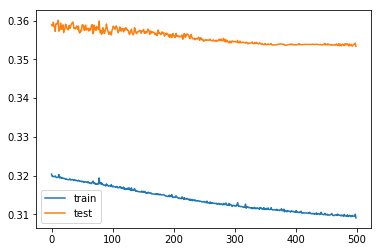

In [70]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

In [72]:
absolute_percentage_error(y_test, model.predict(X_test).reshape(-1))

0.35336962080632317